<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/04%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ego1997","key":"d26531dac0eb01c2a2dd42efeddb3396"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:37<00:00, 228MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.3MB/s]


In [6]:
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [7]:
base_directory = '/content/chest_xray/'

# Define sub-directories for training, validation, and testing data
sub_directories = ['train/', 'val/', 'test/']

# Name of classes
classes = os.listdir(os.path.join(base_directory, sub_directories[0]))

In [8]:
classes

['NORMAL', 'PNEUMONIA']

In [18]:
X = []
y = []

for sub_dir in sub_directories:
    for cls in classes:
        dir_path = os.path.join(base_directory, sub_dir, cls)
        for img in os.listdir(dir_path):
            image = cv2.imread(os.path.join(dir_path, img))
            image = cv2.resize(image, (128, 128))
            image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_RGB = image_RGB / 255.0
            X.append(image_RGB)
            y.append(cls)


In [19]:
# convert list to ndarray
X = np.asarray(X)
y = np.asarray(y)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (5856, 128, 128, 3)
y shape: (5856,)


In [22]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_indices, test_indices = next(splitter.split(X, y))
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_indices, test_indices = next(splitter.split(X_test, y_test))
X_val, X_test = X_test[val_indices], X_test[test_indices]
y_val, y_test = y_test[val_indices], y_test[test_indices]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3513, 128, 128, 3)
y_train shape: (3513,)
X_val shape: (1171, 128, 128, 3)
y_val shape: (1171,)
X_test shape: (1172, 128, 128, 3)
y_test shape: (1172,)


In [24]:
y_train_encoded = np.where(y_train == 'NORMAL', 0, 1)
y_val_encoded = np.where(y_val == 'NORMAL', 0, 1)
y_test_encoded = np.where(y_test == 'NORMAL', 0, 1)

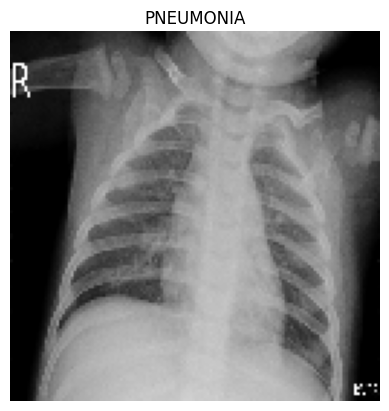

In [25]:
plt.imshow(X_train[0])
plt.title(y_train[0])
plt.axis("Off");
plt.show()